# Notebook 3 - Identifiability

In this notebook we compare two different branching pathways with 4 genes, from both ‘single-cell’ and ‘bulk’ viewpoints.

In [1]:
import numpy as np
from harissa import NetworkModel
from harissa.simulations import BurstyPDMP
from pathlib import Path
data_paths = [
    Path(f'pathways_data1.txt'), 
    Path(f'pathways_data2.txt'),
]

## Networks

In [2]:
nb_genes = 4
models = [
    NetworkModel(nb_genes, simulation=BurstyPDMP(use_numba=True)), # Model 1
    NetworkModel(nb_genes, simulation=BurstyPDMP(use_numba=True)), # Model 2
]

for i, model in enumerate(models):
    model.degradation_rna[:] = 1.0
    model.degradation_protein[:] = 0.2
    model.basal[1:] = -5.0
    model.interaction[0, 1] = 10.0
    model.interaction[1, 2] = 10.0
    model.interaction[1, 3] = 10.0
    model.interaction[2 + i, 4] = 10.0

This time we set the node positions manually to better compare the two networks.

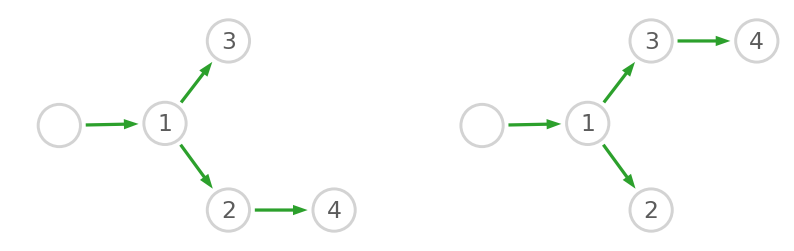

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from harissa.utils import plot_network

fig = plt.figure(figsize=(10,3))
gs = gridspec.GridSpec(1,2)

# Number of genes including stimulus
G = models[0].basal.size

# Node labels and positions
names = [''] + [f'{i+1}' for i in range(4)]
pos = [
    np.array([[-0.6,0],[-0.1,0.01],[0.2,-0.4],[0.2,0.4],[0.7,-0.4]]),
    np.array([[-0.6,0],[-0.1,0.01],[0.2,-0.4],[0.2,0.4],[0.7, 0.4]]),
]

# Draw the networks
for i, model in enumerate(models):
    ax = plt.subplot(gs[0, i])
    plot_network(model.interaction, pos[i], axes=fig.gca(), names=names, scale=6)

## Datasets

Here we use Numba for simulations: this option takes some time to compile (~8s) but is much more efficient afterwards, so it is well suited for large numbers of genes and/or cells.

In [4]:
# Number of cells
C = 10000

# Set the time points
k = np.linspace(0, C, 11, dtype='int')
t = np.linspace(0, 9, 10, dtype='int')
print('Time points: ' + ', '.join([f'{ti}' for ti in t]))
print(f'{int(C/t.size)} cells per time point (total {C} cells)')

time = np.zeros(C, dtype='int')
for i in range(10):
    time[k[i]:k[i+1]] = t[i]

# Prepare data
data_list = [np.zeros((C,G), dtype='int')]
data_list[0][:, 0] = time # Time points
data_list.append(data_list[0].copy())

# Generate data
for k in range(C):
    for i, model in enumerate(models):
        sim = model.simulate(time[k], burn_in=5.0)
        data_list[i][k, 1:] = np.random.poisson(sim.rna_levels[0])

for path, data in zip(data_paths, data_list):
    # Save data in basic format
    np.savetxt(path, data, fmt='%d', delimiter='\t')

Time points: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
1000 cells per time point (total 10000 cells)


## Population-average trajectories

Looking at network structures, it is clear that population-average trajectories, i.e., bulk data, does not contain enough information to recover all interactions: if $d_{0,2}=d_{0,3}$ and $d_{1,2}=d_{1,3}$, one *cannot distinguish* between edges 2 → 4 and 3 → 4 as genes 2 and 3 have the same average dynamics.

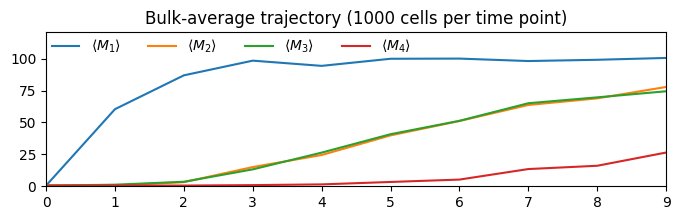

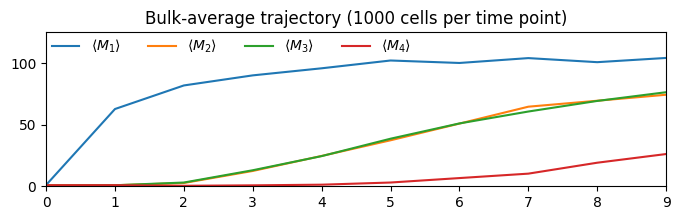

In [5]:
for data in data_list:
    # Import time points
    time = np.sort(list(set(data[:, 0])))
    T = np.size(time)
    # Average for each time point
    traj = np.zeros((T,G-1))
    for k, t in enumerate(time):
        traj[k] = np.mean(data[data[:,0]==t, 1:], axis=0)
    # Draw trajectory and export figure
    fig = plt.figure(figsize=(8,2))
    labels = [rf'$\langle M_{g} \rangle$' for g in range(1,G)]
    plt.plot(time, traj, label=labels)
    ax = plt.gca()
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(0, 1.2*np.max(traj))
    ax.set_xticks(time)
    ax.set_title(f'Bulk-average trajectory ({int(C/T)} cells per time point)')
    ax.legend(loc='upper left', ncol=G, borderaxespad=0, frameon=False)

## Inference from single-cell data

Here, since we know the number of edges we are looking for, we choose to keep only the strongest 4 edges instead of applying a cutoff to the weights.

In [6]:
inter = {}
for k, path in enumerate(data_paths, start=1):
    # Load the data
    data = np.loadtxt(path, dtype=int, delimiter='\t')
    # Calibrate the model
    model = NetworkModel()
    model.fit(data)
    # Keep the strongest four edges
    inter[k] = np.zeros((G,G))
    a = np.abs(model.interaction)
    a -= np.diag(np.diag(a))
    for n in range(4):
        (i,j) = np.unravel_index(np.argmax(a, axis=None), a.shape)
        inter[k][i,j] = model.interaction[i,j]
        a[i,j] = 0
    print(f'inter[{k}] = \n{inter[k]}')

inter[1] = 
[[0.         3.27129179 0.         0.         0.        ]
 [0.         0.         1.73176767 1.7567638  0.        ]
 [0.         0.         0.         0.         0.55909666]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
inter[2] = 
[[0.         3.25938018 0.         0.         0.        ]
 [0.         0.         1.8856155  1.7804052  0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.53599362]
 [0.         0.         0.         0.         0.        ]]


## Drawing inferred networks

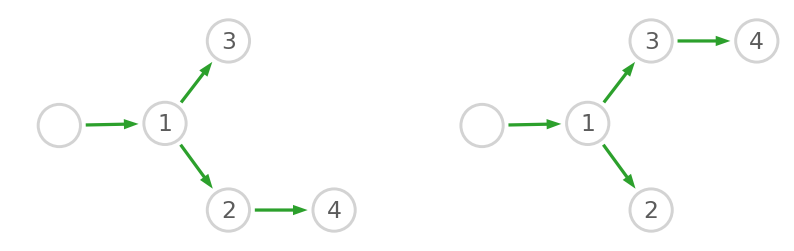

In [7]:
fig = plt.figure(figsize=(10,3))
gs = gridspec.GridSpec(1,2)

# Draw the networks
for i in range(2):
    ax = plt.subplot(gs[0, i])
    plot_network(inter[i + 1], pos[i], axes=fig.gca(), names=names, scale=6)

The result might not be always perfect, but the edges 2 → 4 and 3 → 4 should generally be inferred correctly.